# **Final Project (Classification of Skin Cancer Images)**

In [11]:
import sys
print(sys.executable)

C:\Users\clam3\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe


In [12]:
# Import libraries
import pandas as pd
import numpy as np
from PIL import Image
import os
import cv2
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.metrics import confusion_matrix
# from clr_callback import CyclicLR




## Load the data from the Csv file

Describe the Data and expand on their short-form names for clarity

In [13]:
# Load the metadata of the 10,000 skin images (Data about the image data)
df = pd.read_csv('./HAM10000_metadata.csv', encoding='utf-8')

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,HOG_0,HOG_1,HOG_2,...,lbp_0,lbp_1,lbp_2,lbp_3,lbp_4,lbp_5,lbp_6,lbp_7,lbp_8,lbp_9
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,0.181665,0.108600,0.089247,...,0.041511,0.062126,0.056652,0.121007,0.159637,0.153474,0.098667,0.085300,0.090581,0.131044
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,0.397924,0.397924,0.088924,...,0.038307,0.057678,0.058193,0.130359,0.176733,0.162044,0.098063,0.078744,0.080581,0.119296
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,0.195431,0.204216,0.148832,...,0.033274,0.054156,0.054459,0.131037,0.186785,0.168374,0.098533,0.078341,0.081930,0.113111
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,0.317193,0.317193,0.317193,...,0.042556,0.061863,0.060848,0.129967,0.194763,0.148919,0.092422,0.076285,0.077111,0.115267
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,0.288509,0.288509,0.088875,...,0.019900,0.041715,0.034511,0.133926,0.216181,0.214833,0.090304,0.074704,0.091837,0.082089


**Short-form Notation**

**dx**

akeic = Actinic keratoses and intraepithelial carcinoma / Bowen's disease

bcc = basal cell carcinoma

solar lentigines / seborrheic keratoses and lichen-planus like keratoses, 

bkl = benign keratosis-like lesions

df = dermatofibroma

mel = melanoma

nv = melanocytic nevi

angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, 

vasc = melanocytic nevi (nv) and vascular lesions

**dx_type**

histo = histopathology

follow_up = follow-up examination

consensus = expert consensus

confocal = in-vivo confocal microscopy


# **1 - Data Pre-Processing**

In [14]:
# Remove NULL values from the dataset
df.isnull().sum()

lesion_id     0
image_id      0
dx            0
dx_type       0
age          57
             ..
lbp_5         0
lbp_6         0
lbp_7         0
lbp_8         0
lbp_9         0
Length: 1781, dtype: int64

Since their is 57 NULL values in the age column, remove those values from the data

In [15]:
df = df.dropna(subset=['age'])

# Check if the NULL values have been successfully removed
df.isnull().sum()

lesion_id    0
image_id     0
dx           0
dx_type      0
age          0
            ..
lbp_5        0
lbp_6        0
lbp_7        0
lbp_8        0
lbp_9        0
Length: 1781, dtype: int64

Add the corresponding image path to the metadata csv file

In [16]:
# Merge skin cancer images for the correct path to view
imagePath = './HAM10000_images'

# Pull out the ids from the 'image_id' column
df['full_image_path'] = imagePath + '/' + df['image_id'] + '.jpg'

# Check if the correct image path got added to the dataframe
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,HOG_0,HOG_1,HOG_2,...,lbp_1,lbp_2,lbp_3,lbp_4,lbp_5,lbp_6,lbp_7,lbp_8,lbp_9,full_image_path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,0.181665,0.108600,0.089247,...,0.062126,0.056652,0.121007,0.159637,0.153474,0.098667,0.085300,0.090581,0.131044,./HAM10000_images/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,0.397924,0.397924,0.088924,...,0.057678,0.058193,0.130359,0.176733,0.162044,0.098063,0.078744,0.080581,0.119296,./HAM10000_images/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,0.195431,0.204216,0.148832,...,0.054156,0.054459,0.131037,0.186785,0.168374,0.098533,0.078341,0.081930,0.113111,./HAM10000_images/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,0.317193,0.317193,0.317193,...,0.061863,0.060848,0.129967,0.194763,0.148919,0.092422,0.076285,0.077111,0.115267,./HAM10000_images/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,0.288509,0.288509,0.088875,...,0.041715,0.034511,0.133926,0.216181,0.214833,0.090304,0.074704,0.091837,0.082089,./HAM10000_images/ISIC_0031633.jpg


Transform the 'dx' and 'dx_type' columns into equivalent numerical values

In [17]:
# Change dx to a numerical value for the ML model interpretation
# Using the Label Encoding method
df['dx_numerical'] = df['dx'].astype('category').cat.codes

# Change dx_type to a numerical value for the ML model interpretation
# Using the Label Encoding method
df['dx_type_numerical'] = df['dx_type'].astype('category').cat.codes

# Change gender to a numerical value for the ML model interpretation
# Using the Label Encoding method
df['sex_numerical'] = df['sex'].astype('category').cat.codes

# Change localization to a numerical value for the ML model interpretation
# Using the Label Encoding method
df['localization_numerical'] = df['localization'].astype('category').cat.codes

# Check in data
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,HOG_0,HOG_1,HOG_2,...,lbp_5,lbp_6,lbp_7,lbp_8,lbp_9,full_image_path,dx_numerical,dx_type_numerical,sex_numerical,localization_numerical
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,0.181665,0.108600,0.089247,...,0.153474,0.098667,0.085300,0.090581,0.131044,./HAM10000_images/ISIC_0027419.jpg,2,3,1,11
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,0.397924,0.397924,0.088924,...,0.162044,0.098063,0.078744,0.080581,0.119296,./HAM10000_images/ISIC_0025030.jpg,2,3,1,11
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,0.195431,0.204216,0.148832,...,0.168374,0.098533,0.078341,0.081930,0.113111,./HAM10000_images/ISIC_0026769.jpg,2,3,1,11
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,0.317193,0.317193,0.317193,...,0.148919,0.092422,0.076285,0.077111,0.115267,./HAM10000_images/ISIC_0025661.jpg,2,3,1,11
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,0.288509,0.288509,0.088875,...,0.214833,0.090304,0.074704,0.091837,0.082089,./HAM10000_images/ISIC_0031633.jpg,2,3,1,4


# **2 - Image Pre-processing**

In [18]:
# Load the images into the notebook
# img = cv2.imread('image1.png', cv2.IMREAD_GRAYSCALE)

# Create a new column for the images (125:w by 100:h)
df['skin_image'] = df['full_image_path'].map(lambda x: np.asarray(Image.open(x).resize((125, 100))))

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,HOG_0,HOG_1,HOG_2,...,lbp_6,lbp_7,lbp_8,lbp_9,full_image_path,dx_numerical,dx_type_numerical,sex_numerical,localization_numerical,skin_image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,0.181665,0.108600,0.089247,...,0.098667,0.085300,0.090581,0.131044,./HAM10000_images/ISIC_0027419.jpg,2,3,1,11,"[[[189, 152, 194], [192, 156, 198], [191, 154,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,0.397924,0.397924,0.088924,...,0.098063,0.078744,0.080581,0.119296,./HAM10000_images/ISIC_0025030.jpg,2,3,1,11,"[[[24, 13, 22], [24, 14, 22], [24, 14, 26], [2..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,0.195431,0.204216,0.148832,...,0.098533,0.078341,0.081930,0.113111,./HAM10000_images/ISIC_0026769.jpg,2,3,1,11,"[[[186, 127, 135], [189, 133, 145], [192, 135,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,0.317193,0.317193,0.317193,...,0.092422,0.076285,0.077111,0.115267,./HAM10000_images/ISIC_0025661.jpg,2,3,1,11,"[[[24, 11, 17], [24, 11, 20], [30, 15, 25], [4..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,0.288509,0.288509,0.088875,...,0.090304,0.074704,0.091837,0.082089,./HAM10000_images/ISIC_0031633.jpg,2,3,1,4,"[[[131, 88, 110], [142, 97, 120], [152, 107, 1..."


In [19]:
print(df.columns)  # Show available columns
print(df.head())  # Display first few rows

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'HOG_0', 'HOG_1', 'HOG_2',
       ...
       'lbp_6', 'lbp_7', 'lbp_8', 'lbp_9', 'full_image_path', 'dx_numerical',
       'dx_type_numerical', 'sex_numerical', 'localization_numerical',
       'skin_image'],
      dtype='object', length=1787)
     lesion_id      image_id   dx dx_type   age   sex localization     HOG_0  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp  0.181665   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp  0.397924   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp  0.195431   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp  0.317193   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear  0.288509   

      HOG_1     HOG_2  ...     lbp_6     lbp_7     lbp_8     lbp_9  \
0  0.108600  0.089247  ...  0.098667  0.085300  0.090581  0.131044   
1  0.397924  0.088924  ...  0.098063  0.078744  0

In [20]:
print(df['skin_image'])

0        [[[189, 152, 194], [192, 156, 198], [191, 154,...
1        [[[24, 13, 22], [24, 14, 22], [24, 14, 26], [2...
2        [[[186, 127, 135], [189, 133, 145], [192, 135,...
3        [[[24, 11, 17], [24, 11, 20], [30, 15, 25], [4...
4        [[[131, 88, 110], [142, 97, 120], [152, 107, 1...
                               ...                        
10010    [[[143, 125, 134], [140, 122, 131], [140, 122,...
10011    [[[5, 6, 3], [6, 7, 4], [7, 8, 5], [8, 8, 6], ...
10012    [[[109, 99, 102], [122, 111, 112], [132, 121, ...
10013    [[[157, 121, 143], [160, 125, 145], [155, 114,...
10014    [[[179, 147, 132], [177, 146, 137], [177, 141,...
Name: skin_image, Length: 9958, dtype: object


# **Load LBP Features**

In [21]:
# Load existing metadata file with LBP
# df = pd.read_csv('./HAM10000_metadata.csv')

# Drop rows with missing age again if needed
df = df.dropna(subset=['age'])

# Load LBP columns
lbp_columns = [col for col in df.columns if col.startswith('lbp_')]
X_lbp = df[lbp_columns].values


More Image Pre-processing

__Feature Extraction Technique__

SIFT - To extract key points and descriptors for object recognition

In [22]:
# Detect the keypoints and create the descriptor
# sift = cv2.xfeatures2d.SIFT_create()

**Adding a Histogram of Oriented Gradients**

In [23]:

# Load HOG columns
hog_columns = [col for col in df.columns if col.startswith('HOG_')]
X_hog = df[hog_columns].values


# **3 - Data Visualization w/h Graphs**

Text(0, 0.5, 'Count')

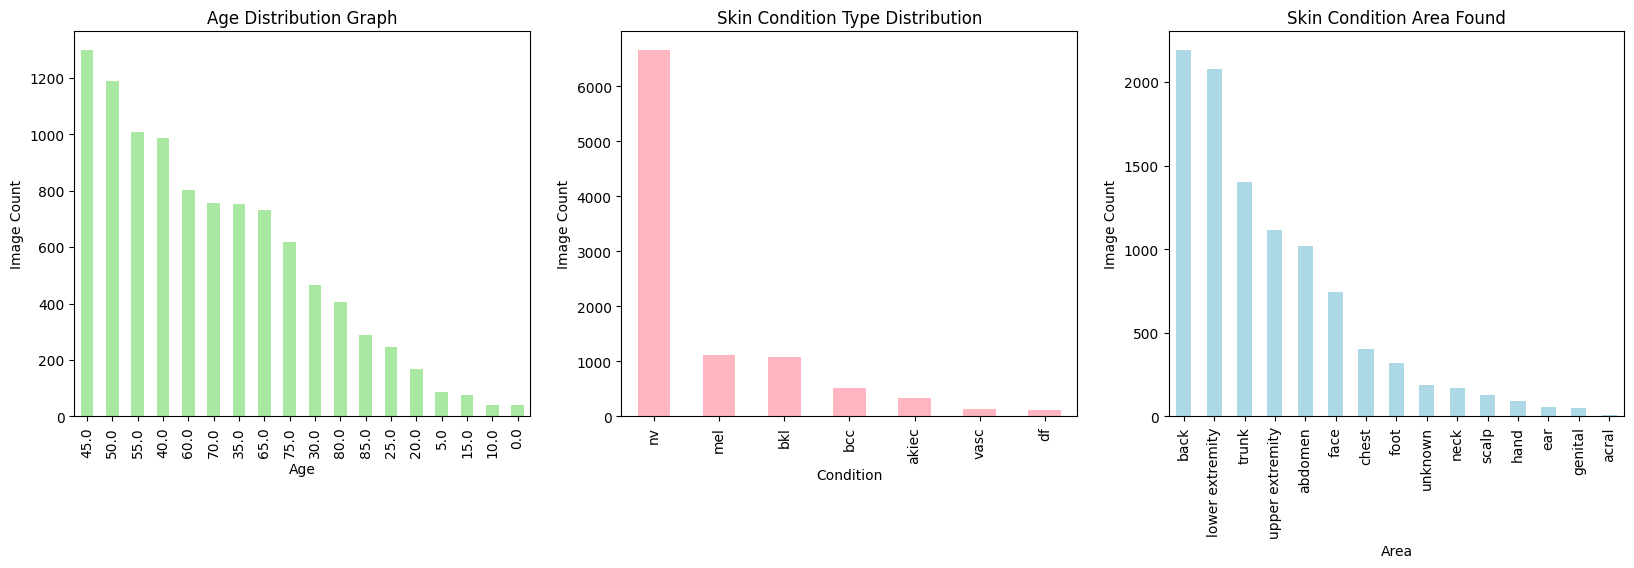

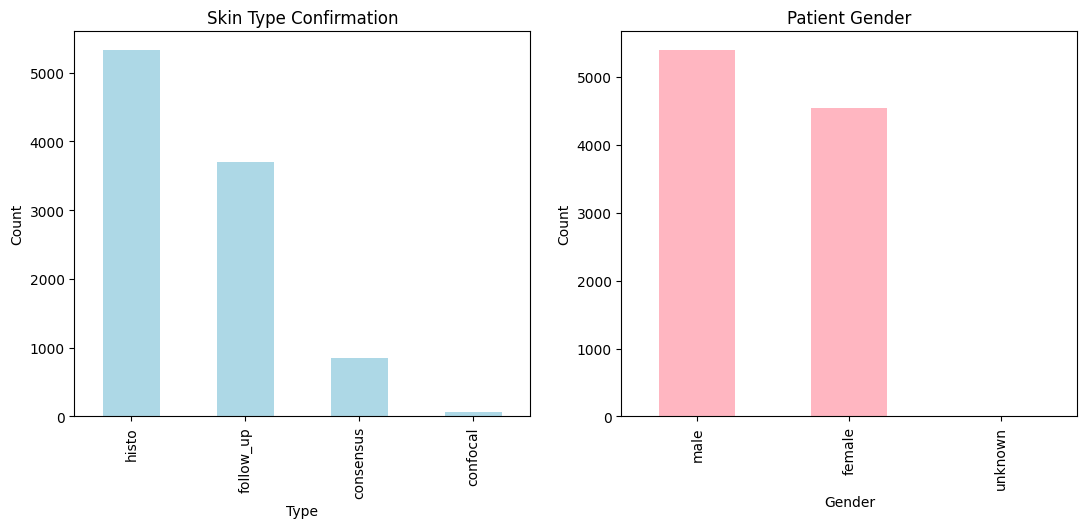

In [24]:
plt.figure(figsize=(20, 5))

# Plot the ages
plt.subplot(1, 3, 1)
plt.title("Age Distribution Graph")
df['age'].value_counts().plot.bar(color='#A8E8A3')
plt.xlabel("Age")
plt.ylabel("Image Count")

# Plot the Skin Condition Type
plt.subplot(1, 3, 2)
plt.title("Skin Condition Type Distribution")
df['dx'].value_counts().plot.bar(color='lightpink')
plt.xlabel("Condition")
plt.ylabel("Image Count")

# Plot the Area Skin Condition was found
plt.subplot(1, 3, 3)
plt.title("Skin Condition Area Found")
df['localization'].value_counts().plot.bar(color='lightblue')
plt.xlabel("Area")
plt.ylabel("Image Count")

plt.figure(figsize=(20, 5))

# Plot the type of confirmation of the skin type from health-care professionals
plt.subplot(1, 3, 1)
plt.title("Skin Type Confirmation")
df['dx_type'].value_counts().plot.bar(color='lightblue')
plt.xlabel("Type")
plt.ylabel("Count")

# Plot the gender distribution of the data
plt.subplot(1, 3, 2)
plt.title("Patient Gender")
df['sex'].value_counts().plot.bar(color='lightpink')
plt.xlabel("Gender")
plt.ylabel("Count")


# **4 - CNN ML Model**

In [133]:
# Import the necessary libraries
# from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization,Conv2D, MaxPool2D
# from keras.optimizers import Adam
# from keras.callbacks import ReduceLROnPlateau
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Splitting the Data
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Implement the CNN Keras libraries
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, concatenate
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight

import keras_tuner as kt


In [84]:
print(df.columns)  # Show available columns
print(df.head())  # Display first few rows


Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'HOG_0', 'HOG_1', 'HOG_2',
       ...
       'lbp_6', 'lbp_7', 'lbp_8', 'lbp_9', 'full_image_path', 'dx_numerical',
       'dx_type_numerical', 'sex_numerical', 'localization_numerical',
       'skin_image'],
      dtype='object', length=1787)
     lesion_id      image_id   dx dx_type   age   sex localization     HOG_0  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp  0.181665   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp  0.397924   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp  0.195431   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp  0.317193   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear  0.288509   

      HOG_1     HOG_2  ...     lbp_6     lbp_7     lbp_8     lbp_9  \
0  0.108600  0.089247  ...  0.098667  0.085300  0.090581  0.131044   
1  0.397924  0.088924  ...  0.098063  0.078744  0

Train, Test, Split the Data

- Test size: 20%
- Training size: 80%

In [134]:
# Split the excel file into training data for X and Y
Y = df['dx_numerical']
X_image = df.drop(labels = ['dx_numerical'], axis = 1)

# Seperate the other features (other then image pixel values)
X_other = df[['dx_type_numerical', 'sex_numerical', 'localization_numerical']]

X_image_train, X_image_test, X_other_train, X_other_test, X_lbp_train, X_lbp_test, X_hog_train, X_hog_test, Y_train, Y_test = train_test_split(
    X_image, X_other, X_lbp, X_hog, Y, test_size=0.2, random_state=2
)

# Reshape the training data and test X data
X_train = np.asarray(X_image_train['skin_image'].tolist())
X_test = np.asarray(X_image_test['skin_image'].tolist())

# Reshape the image into 3 dimensions
X_train = X_train.reshape(X_train.shape[0], *(100, 125, 3))
X_test = X_test.reshape(X_test.shape[0], *(100, 125, 3))

# Process the other features
X_other_train = X_other_train.values
X_other_test = X_other_test.values

# Transform train and testing of Y to categorical
Y_train = to_categorical(Y_train, num_classes=7)
Y_test = to_categorical(Y_test, num_classes=7)

print("x_train Reshaped", X_train.shape)
print("x_test Reshaped", X_test.shape)
print("y_train Reshaped", Y_train.shape)
print("y_test Reshaped", Y_test.shape)


x_train Reshaped (7966, 100, 125, 3)
x_test Reshaped (1992, 100, 125, 3)
y_train Reshaped (7966, 7)
y_test Reshaped (1992, 7)


**Data Augmentation**

Testing the Commented Out Below

In [135]:
# # Perform data augmentation to prevent overfitting
# datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
#         rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
#         zoom_range = 0.1, # Randomly zoom image 
#         width_shift_range=0.12,  # randomly shift images horizontally (fraction of total width)
#         height_shift_range=0.12,  # randomly shift images vertically (fraction of total height)
#         horizontal_flip=True,  # randomly flip images
#         vertical_flip=True)  # randomly flip images

# datagen.fit(X_train)

# Initialize the ImageDataGenerator for image augmentation
# # This code was NOT giving good results --> 68% training accuracy
# image_datagen = ImageDataGenerator(
#     rotation_range=30,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# Currently not giving good results
datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.12,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.12,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,      # randomly flip images
        fill_mode='nearest'     # Fill empty pixels with nearest value
)  

# Augment images from X_train
augmented_images = []
augmented_labels = []
aug_X_other = []
aug_X_lbp = []
aug_X_hog = []

for i in range(len(X_train)):
    img = X_train[i]  # Get image
    metadata = X_other_train[i]
    lbp_features = X_lbp_train[i]
    hog_features = X_hog_train[i]
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    augmented_iter = datagen.flow(img, batch_size=1)  # Apply augmentation
    
    # Generate 3 augmented versions per image
    for _ in range(6):  
        aug_img = next(augmented_iter)[0]  # Get augmented image
        augmented_images.append(aug_img)
        augmented_labels.append(Y_train[i])  # Keep the same label
        aug_X_other.append(metadata)
        aug_X_lbp.append(lbp_features)
        aug_X_hog.append(hog_features)

# Convert lists to numpy arrays
X_train_aug = np.array(augmented_images)
Y_train_aug = np.array(augmented_labels)
X_other_train_aug = np.array(aug_X_other)
X_lbp_train_aug = np.array(aug_X_lbp)
X_hog_train_aug = np.array(aug_X_hog)

# Merge original and augmented data
X_train = np.concatenate((X_train, X_train_aug), axis=0)
Y_train = np.concatenate((Y_train, Y_train_aug), axis=0)
X_other_train = np.concatenate((X_other_train, X_other_train_aug), axis=0)
X_lbp_train = np.concatenate((X_lbp_train, X_lbp_train_aug), axis=0)
X_hog_train = np.concatenate((X_hog_train, X_hog_train_aug), axis=0)

print("Augmented X_train shape:", X_train.shape)
print("Augmented Y_train shape:", Y_train.shape)
print("X_other_train_final:", X_other_train.shape)
print("X_lbp_train_final:", X_lbp_train.shape)
print("X_hog_train_final:", X_hog_train.shape)

Augmented X_train shape: (55762, 100, 125, 3)
Augmented Y_train shape: (55762, 7)
X_other_train_final: (55762, 3)
X_lbp_train_final: (55762, 10)
X_hog_train_final: (55762, 1764)


**Normalize the Image Pixel Data**

In [136]:
# # Get the mean and standard deviation of the training images
# x_train_mean = np.mean(X_train)
# x_train_std = np.std(X_train)

# # Get the mean and standard deviation of the test images
# x_test_mean = np.mean(X_test)
# x_test_std = np.std(X_test)

# # Normalize the training and test image data
# x_train = (X_train - x_train_mean)/x_train_std
# x_test = (X_test - x_test_mean)/x_test_std

# Use min-max scaling to normalize the images (Good for ReLU activations)
X_train = X_train / 255.0
X_test = X_test / 255.0

Create the CNN Model

In [137]:
model = Sequential()

input_shape = (100, 125, 3)
num_classes = 7

# Image branch
image_input = Input(shape=input_shape)  # Define image input
x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(image_input)
x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
x = Dropout(0.2)(x)

x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
x = Dropout(0.2)(x)

x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
x = Dropout(0.2)(x)

x = Flatten()(x)    # Flatten the CNN output

# Other features input branch - Numerical Data Input
other_input = Input(shape=(X_other_train.shape[1],))
other_output = Dense(64, activation='relu')(other_input)
other_output = Dense(32, activation='relu')(other_output)


#LBP input branch
lbp_input = Input(shape=(X_lbp_train.shape[1],), name="lbp_input")
l = Dense(128, activation='relu')(lbp_input)
l = Dense(64, activation='relu')(l)

# # HOG input branch
# hog_input = Input(shape=(X_hog_train.shape[1],), name="hog_input")
# h = Dense(64, activation='relu')(hog_input)
# h = Dense(64, activation='relu')(h)



# Combine branches of CNN and other features together
# merged = concatenate([x, other_output, l, h])
merged = concatenate([x, other_output, l])
z = Dense(64, activation='relu')(merged)
z = Dense(128, activation='relu')(z)
z = Dropout(0.5)(z)
output = Dense(num_classes, activation="softmax")(z)

# Create model
# model = Model(inputs=[image_input, other_input, lbp_input, hog_input], outputs=output)
model = Model(inputs=[image_input, other_input, lbp_input], outputs=output)

# Compile the model
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

**Define a Keras Tuner Search Function --> To automatically find the best number of layers**

In [ ]:
def build_model(hp):
    input_shape = (100, 125, 3)
    num_classes = 7
    
    # Image Input
    image_input = Input(shape=input_shape, name="image_input")
    
    # Convolutional Layers (Variable Number & Filters)
    x = image_input
    for i in range(hp.Int('num_conv_layers', 2, 5)):  # Tune between 2 and 5 conv layers
        filters = hp.Int(f'filters_{i}', 32, 128, step=32)  # Tune filters (32-128)
        x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation='relu')(x)
        x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation='relu')(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(rate=hp.Choice(f'dropout_{i}', [0.2, 0.3, 0.4]))(x)  # Tune dropout
    
    x = Flatten()(x)  # Flatten CNN output

    # Other Features Input
    other_input = Input(shape=(X_other_train.shape[1],), name="other_input")
    other_output = Dense(hp.Int('other_dense_1', 16, 64, step=16), activation='relu')(other_input)
    other_output = Dense(hp.Int('other_dense_2', 8, 32, step=8), activation='relu')(other_output)

    # LBP Input
    lbp_input = Input(shape=(X_lbp_train.shape[1],), name="lbp_input")
    l = Dense(hp.Int('lbp_dense_1', 32, 128, step=32), activation='relu')(lbp_input)
    l = Dense(hp.Int('lbp_dense_2', 16, 64, step=16), activation='relu')(l)

    # HOG Input
    hog_input = Input(shape=(X_hog_train.shape[1],), name="hog_input")
    h = Dense(hp.Int('hog_dense_1', 32, 128, step=32), activation='relu')(hog_input)
    h = Dense(hp.Int('hog_dense_2', 16, 64, step=16), activation='relu')(h)

    # Merge All Inputs
    merged = concatenate([x, other_output, l, h])
    
    # Fully Connected Layers (Variable Units)
    z = Dense(hp.Int('dense_1', 64, 256, step=64), activation='relu')(merged)
    z = Dense(hp.Int('dense_2', 32, 128, step=32), activation='relu')(z)
    z = Dropout(0.5)(z)
    
    output = Dense(num_classes, activation="softmax")(z)

    model = Model(inputs=[image_input, other_input, lbp_input, hog_input], outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

Define Optimizer

In [61]:
# Define the optimizer
# optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)

# Compile the model
model.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

# print(model.summary())

# print(model.input_shape)

for i, inp in enumerate(model.inputs):
    print(f"Input {i+1} shape:", inp.shape)

print(model.output_shape)

# Grab only the first 7966 instances for the numerical values from the other categories
X_other = X_other[:7966]  # Trim to match image data


print("Model Input 1 Expected:", model.input_shape[0])
print("Model Input 2 Expected:", model.input_shape[1])
print("Model Output Expected:", model.output_shape)

print("X_train_image Shape:", X_train.shape)
print("X_other Shape:", X_other.shape)
print("Y_train Shape:", Y_train.shape)



# Set the epochs and batch size
epochs = 40
batch_size = 10

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


Input 1 shape: (None, 100, 125, 3)
Input 2 shape: (None, 3)
Input 3 shape: (None, 10)
Input 4 shape: (None, 1764)
(None, 7)
Model Input 1 Expected: (None, 100, 125, 3)
Model Input 2 Expected: (None, 3)
Model Output Expected: (None, 7)
X_train_image Shape: (7966, 100, 125, 3)
X_other Shape: (7966, 3)
Y_train Shape: (7966, 7)


**Fit the CNN Model**

Ignore Below Commented Out - Testing Data Augmentation Model Fit

In [50]:
# def data_generator_with_augmentation(image_data, numerical_data, labels, batch_size=batch_size):
#     image_gen = image_datagen.flow(image_data, batch_size=batch_size, shuffle=True)
#     num_samples = len(image_data)
    
#     while True:
#         for i in range(0, num_samples, batch_size):
#             # Generate the next batch of augmented images
#             augmented_images = next(image_gen)

#             # Debugging the shapes of the data
#             # print(f"augmented_images shape: {augmented_images.shape}")
#             # print(f"numerical_data shape: {numerical_data.shape}")
            
#             # Get the corresponding batch of numerical data and labels
#             batch_numerical_data = numerical_data[i:i+batch_size]
#             batch_labels = labels[i:i+batch_size]
            
#             # Convert batches to tensors
#             augmented_images = tf.convert_to_tensor(augmented_images, dtype=tf.float32)
#             batch_numerical_data = tf.convert_to_tensor(batch_numerical_data, dtype=tf.float32)
#             batch_labels = tf.convert_to_tensor(batch_labels, dtype=tf.float32)

#             # print(f"augmented_images (tensor) shape: {augmented_images.shape}")
#             # print(f"batch_numerical_data (tensor) shape: {batch_numerical_data.shape}")
#             # print(f"batch_labels (tensor) shape: {batch_labels.shape}")
            
#             # Yield the batch
#             yield (augmented_images, batch_numerical_data), batch_labels

# # Create a tf.data.Dataset from the generator
# def create_tf_dataset(image_data, numerical_data, labels, batch_size):
#     dataset = tf.data.Dataset.from_generator(
#         lambda: data_generator_with_augmentation(image_data, *numerical_data, labels, batch_size),
#         output_signature=(
#             (tf.TensorSpec(shape=(None, 100, 125, 3), dtype=tf.float32),
#              tf.TensorSpec(shape=(None, 3), dtype=tf.float32),  # Adjust shape if needed
#              tf.TensorSpec(shape=(None, 3), dtype=tf.float32),
#              tf.TensorSpec(shape=(None, 3), dtype=tf.float32)),
#             tf.TensorSpec(shape=(None, 7), dtype=tf.float32)
#         )
#     )
#     return dataset

# # Create the dataset
# train_dataset = create_tf_dataset(X_train, (X_other_train, X_lbp_train, X_hog_train), Y_train, batch_size=batch_size)
# val_dataset = create_tf_dataset(X_test, (X_other_test, X_lbp_test, X_hog_test), Y_test, batch_size=batch_size)

# # Example of training with the multi-input CNN model
# history = model.fit(
#     train_dataset,
#     # validation_data=val_dataset,
#     validation_data=([X_test, X_other_test, X_lbp_test, X_hog_test], Y_test),  # Use tuple of arrays
#     epochs=50,
#     verbose=1,
#     steps_per_epoch=X_train.shape[0] // batch_size,
#     callbacks=[learning_rate_reduction]
# )

# # Example of training with a multi-input CNN model
# history = model.fit(
#     data_generator_with_augmentation(X_train, X_other_train, Y_train, batch_size=batch_size),
#     validation_data=([X_test, X_other_test], Y_test),
#     epochs=10,
#     verbose=1

#     # datagen.flow(X_train, Y_train, batch_size=batch_size),
#     # epochs=epochs,
#     # validation_data=(X_test, Y_test),
#     # verbose=1,
#     # steps_per_epoch=X_train.shape[0] // batch_size,
#     # callbacks=[learning_rate_reduction]
# )

**Actual CNN model to Fit**

In [138]:
# Set the epochs and batch size
epochs = 40
# batch_size = 15
batch_size = 32
batch_size = 64

# Perform early stopping of epoches if model performance stops improving
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor the validation accuracy
    patience=5,          # Number of epochs to wait before stopping
    restore_best_weights=True  # Restores the best model weights
)

In [127]:
# Convert one-hot encoded labels back to class labels
if len(Y_train.shape) > 1:  # Check if Y_train is one-hot encoded
    Y_train_labels = np.argmax(Y_train, axis=1)  # Convert to class indices
else:
    Y_train_labels = Y_train  # Already in the right format

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(Y_train_labels), y=Y_train_labels)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [139]:
# Try the model.fit with NumPy arrays [THIS GIVES 85.5% accuracy!]
history = model.fit(
    # [X_train, X_other_train, X_lbp_train, X_hog_train],
    [X_train, X_other_train, X_lbp_train],
    Y_train,
    # validation_data=([X_test, X_other_test, X_lbp_test, X_hog_test], Y_test),
    validation_data=([X_test, X_other_test, X_lbp_test], Y_test),
    epochs=epochs,
    verbose=1,
    batch_size=batch_size,
    # callbacks=[learning_rate_reduction]
    callbacks=[early_stopping]
    # class_weight=class_weights_dict   # Add class weights
)

print(history.history) #print the history

Epoch 1/40


C:\Users\clam3\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_266', 'keras_tensor_284', 'lbp_input']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


872/872 ━━━━━━━━━━━━━━━━━━━━ 859s 981ms/step - accuracy: 0.6641 - loss: 1.0322 - val_accuracy: 0.6908 - val_loss: 0.7670
Epoch 2/40
872/872 ━━━━━━━━━━━━━━━━━━━━ 871s 999ms/step - accuracy: 0.7100 - loss: 0.7426 - val_accuracy: 0.7400 - val_loss: 0.6834
Epoch 3/40
872/872 ━━━━━━━━━━━━━━━━━━━━ 855s 981ms/step - accuracy: 0.7311 - loss: 0.6854 - val_accuracy: 0.7535 - val_loss: 0.6465
Epoch 4/40
872/872 ━━━━━━━━━━━━━━━━━━━━ 855s 980ms/step - accuracy: 0.7557 - loss: 0.6415 - val_accuracy: 0.7751 - val_loss: 0.6023
Epoch 5/40
872/872 ━━━━━━━━━━━━━━━━━━━━ 854s 979ms/step - accuracy: 0.7698 - loss: 0.6067 - val_accuracy: 0.7771 - val_loss: 0.5940
Epoch 6/40
872/872 ━━━━━━━━━━━━━━━━━━━━ 853s 978ms/step - accuracy: 0.7756 - loss: 0.5856 - val_accuracy: 0.7851 - val_loss: 0.5752
Epoch 7/40
872/872 ━━━━━━━━━━━━━━━━━━━━ 852s 977ms/step - accuracy: 0.7809 - loss: 0.5656 - val_accuracy: 0.7957 - val_loss: 0.5666
Epoch 8/40
872/872 ━━━━━━━━━━━━━━━━━━━━ 855s 980ms/step - accuracy: 0.7896 - loss: 0.54

In [140]:
# Save the model
model.save("cnn_with_image_other_lbp_rotation_6_0.81.keras")

**Run Keras Tuner to Find the Best Model**

In [56]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Number of different models to try
    executions_per_trial=1,  # Run each model once
    directory='tuner_results',
    project_name='cnn_tuning'
)

tuner.search(
    [X_train, X_other_train, X_lbp_train, X_hog_train], 
    Y_train, 
    epochs=10, 
    validation_data=([X_test, X_other_test, X_lbp_test, X_hog_test], Y_test)
)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Trial 10 Complete [00h 45m 45s]
val_accuracy: 0.7294176816940308

Best val_accuracy So Far: 0.7479919791221619
Total elapsed time: 06h 19m 17s


C:\Users\clam3\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 70 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 100, 125,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 100, 125,  │      1,792 │ image_input[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 100, 125,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 50, 62,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 50, 62,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 50, 62,    │     36,928 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 50, 62,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 25, 31,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 25, 31,    │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 25, 31,    │     18,464 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 25, 31,    │      9,248 │ conv2d_4[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 12, 15,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 12, 15,    │          0 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 12, 15,    │      9,248 │ dropout_2[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 12, 15,    │      9,248 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 6, 7, 32)  │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ other_input         │ (None, 3)         │          0 │ -               

 Total params: 393,447 (1.50 MB)

 Trainable params: 393,447 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Save the model
# best_model.save("best_cnn_model.keras")

**Evaluate the multi-classification model performance**

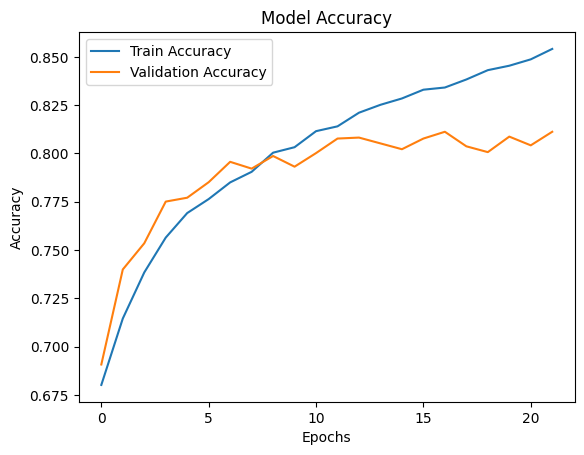

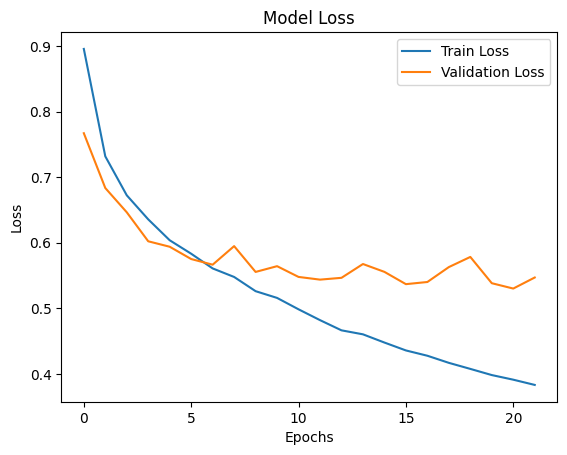

In [141]:
# Plot the training and validation loss/accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Plot the loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [143]:
# Evaluate on the test set
test_loss, test_acc = model.evaluate(
    # [X_test, X_other_test, X_lbp_test, X_hog_test],  # Multiple inputs
    [X_test, X_other_test, X_lbp_test],  # Multiple inputs
    Y_test
)

print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - accuracy: 0.8026 - loss: 0.5660
Test Accuracy: 0.8112, Test Loss: 0.5402


C:\Users\clam3\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_266', 'keras_tensor_284', 'lbp_input']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step


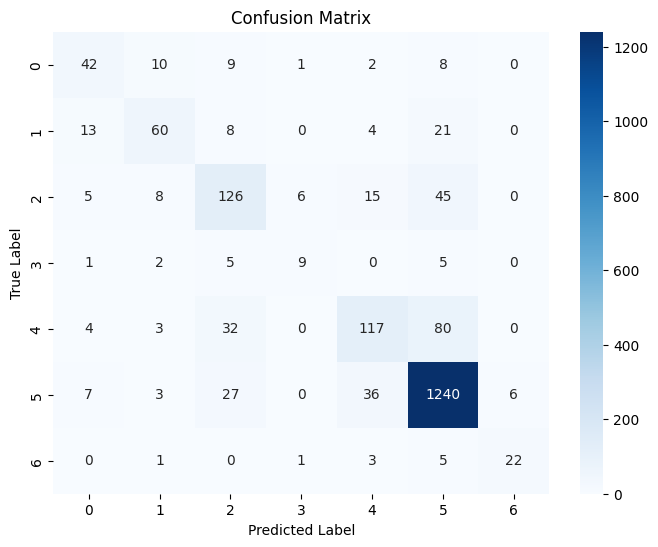

In [145]:
# Compute the Confusion Matrix
# Get model predictions
# y_pred = model.predict([X_test, X_other_test, X_lbp_test, X_hog_test])
y_pred = model.predict([X_test, X_other_test, X_lbp_test])
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(Y_test, axis=1)  # Convert one-hot labels to class labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(len(cm)), yticklabels=range(len(cm)))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [146]:
# Compute Accuracy
accuracy = accuracy_score(y_true, y_pred_classes)

# Compute Precision, Recall, F1-score for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred_classes, average=None)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, digits=4))

# Print overall accuracy
print(f"Accuracy: {accuracy:.4f}")

Classification Report:
              precision    recall  f1-score   support

           0     0.5833    0.5833    0.5833        72
           1     0.6897    0.5660    0.6218       106
           2     0.6087    0.6146    0.6117       205
           3     0.5294    0.4091    0.4615        22
           4     0.6610    0.4958    0.5666       236
           5     0.8832    0.9401    0.9108      1319
           6     0.7857    0.6875    0.7333        32

    accuracy                         0.8112      1992
   macro avg     0.6773    0.6138    0.6413      1992
weighted avg     0.8020    0.8112    0.8042      1992

Accuracy: 0.8112
